In [1]:
import re
import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame
import sklearn.preprocessing as preprocessing
import scipy.io as sio
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
#导入Scikit learn库中的KNN算法
from sklearn import svm
#从sklearn库中导入svm
from sklearn import cross_validation
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

H:\Vision\Anconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def changeDtype(src,dstdtype='int64'):
    a=src.values
    a=np.array(a,dtype=dstdtype)
    return a


def setName(data):
#     print(data)
    name=[]
    Mr='^.* Mr\. .*$'
    Miss='^.* Miss\. .*$'
    Mrs='^.* Mrs\. .*$'
    Master='^.* Master\. .*$'
    lens = len(data)
    print(lens)
    Name_num=data.copy()
    for i in range(lens):
        if re.match(Mr,data[i]):
            name.append('Mr')
            data.loc[i]='Mr'
            Name_num.loc[i]=0
        elif re.match(Miss,data[i]):
            name.append('Miss')
            data.loc[i]='Miss'
            Name_num.loc[i]=1
        elif re.match(Mrs,data[i]):
            name.append('Mrs')
            data.loc[i]='Mrs'
            Name_num.loc[i]=2
        elif re.match(Master,data[i]):
            name.append('Master')
            data.loc[i]='Master'
            Name_num.loc[i]=3
        else:
            name.append('Norm')
            data.loc[i]='Norm'
            Name_num.loc[i]=4
#     print(len(name),name)
    #转换类型
    Name_num=changeDtype(Name_num)
#     print(data.values)
    return data,Name_num
#分别显示获救和未获救的曲线（数据为连续实数：dataflag=‘real’），或者直方图（数据为离散类别：dataflag='class'）
def showDataFig(surviveddatalist,notsurviveddatalist,flag,title=None):
    if(flag=='real'):#实数
        surviveddatalist.plot(kind='kde')   
        notsurviveddatalist.plot(kind='kde')
        plt.legend((u'获救', u'未获救'),loc='best')
    elif(flag=='class'):
        #顺便统计有没有缺失值，给空出来
        df=pd.DataFrame({ u'未获救':notsurviveddatalist.value_counts(),'获救':surviveddatalist.value_counts()})
        df.plot(kind='bar', stacked=True)
    else:
        return;
    if title!=None:
        plt.title(title)
    plt.show()
#对有无Age分开
def getAgeData(data):
    scaler = preprocessing.StandardScaler()
    data_hasAge = data[pd.notnull(data.Age)]
    age_scale_param = scaler.fit(data_hasAge['Age'])
    data_hasAge['Age_scaled'] = scaler.fit_transform(data_hasAge['Age'], age_scale_param)
    # 没有Age
    data_noAge = data[pd.isnull(data.Age)]
    data_noAge.drop(['Age'], axis=1, inplace=True)
    return data_hasAge,data_noAge


def set_missing_ages(data,featurelist):
    df=data.copy()
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[featurelist]
    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[df.Age.notnull()].as_matrix()
    unknown_age = age_df[df.Age.isnull()].as_matrix()

    # y即目标年龄
    y = df[df.Age.notnull()].Age.as_matrix()
    # X即特征属性值
    X = known_age

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age)
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges
    return df

#ratio为取测试样本的比例
#ratio=0则表示只取训练集，带标签
#ratio=1则表示只取测试集，不带标签
def predata(file_path='./dataset/train.csv',savefile=True,savepath='./data',ratio=0.2,predataflag=1):
    #读取
    # 载入数据,如果存在保存的数据，则直接载入保存数据
    if savefile and os.path.exists(savepath + '/'+  'Titanic_data' + "_" + str(ratio)+'.mat') == True:
        #直接载入数据
        print('从已保存数据载入...')
        DataSetMat = sio.loadmat(savepath + '/'+  'Titanic_data' + "_" + str(ratio)+"_predataflag"+str(predataflag)+'.mat')
        if(ratio==0):
            return np.array([]),np.array([]),np.array(DataSetMat['Tr']),np.array(DataSetMat['Tr_l'])[0]
        return np.array(DataSetMat['Te']),np.array(DataSetMat['Te_l'])[0],np.array(DataSetMat['Tr']),np.array(DataSetMat['Tr_l'])[0]
    else:
        print("the dataset you selected dos'nt exist!!! working on data preprocess!")
    #否则，预处理数据
    data_train = pd.read_csv(file_path)
    data_len=len(data_train)
    test_number=int(ratio*(data_len))
    train_number=data_len-test_number
    print('总样本集为%d行，取测试集比例%f，取%d个测试集，%d个训练集'%(data_len,ratio,test_number,train_number))
    data_pre = data_train.copy()
    # 预处理数据，离散的映射到类别空间，连续的映射到[0,1]
#     data_pre.drop(['Name', 'Ticket'], axis=1, inplace=True)
    data_pre.drop(['Ticket'], axis=1, inplace=True)
    #匹配Name并离散化为变量，Name_num
    data_pre['NameExtens'],data_pre['Name_num'] = setName(data_pre['Name'].copy)
    # 离散值映射
    data_pre.loc[(data_pre.Sex == 'male'), 'Sex'] = 0
    data_pre.loc[(data_pre.Sex == 'female'), 'Sex'] = 1
    data_pre.Sex = changeDtype(data_pre.Sex)

    data_pre.loc[(data_pre.Cabin.notnull()), 'Cabin'] = 1
    data_pre.loc[(data_pre.Cabin.isnull()), 'Cabin'] = 0
    data_pre.Cabin = changeDtype(data_pre.Cabin)

    data_pre.loc[(data_pre.Embarked.isnull()), 'Embarked'] = 0
    data_pre.loc[(data_pre.Embarked == 'Q'), 'Embarked'] = 1
    data_pre.loc[(data_pre.Embarked == 'S'), 'Embarked'] = 2
    data_pre.loc[(data_pre.Embarked == 'C'), 'Embarked'] = 3
    data_pre.Embarked = changeDtype(data_pre.Embarked)
    data_pre.loc[(data_pre.Parch != 0), 'Parch'] = 1
    data_pre.loc[(data_pre.SibSp != 0), 'SibSp'] = 1
    # 对实数变量，缩放到0-1
    #fare是票价，如果缺失，则用其所在Pclass的类别的Fare的均值填充
    # 对缺失的Fare，用Pclass对应的mean补上
    Fare_mean = [data_pre[data_pre.Pclass == 1]['Fare'].mean(), data_pre[data_pre.Pclass == 2]['Fare'].mean(),
                 data_pre[data_pre.Pclass == 3]['Fare'].mean()]
    Fare_mean = np.array(Fare_mean)
    data_pre.loc[pd.isnull(data_pre.Fare), 'Fare'] = Fare_mean[data_pre[pd.isnull(data_pre.Fare)]['Pclass'].as_matrix() - 1]
    
    scaler = preprocessing.StandardScaler()
    fare_scale_param = scaler.fit(data_pre['Fare'])
    data_pre['Fare_scaled'] = scaler.fit_transform(data_pre['Fare'], fare_scale_param)
    #预测缺失的age值
    # 对缺失的Age，
    has_Age=data_pre[pd.notnull(data_pre.Age)]
    #求称呼对应的年龄均值
    Age_mean = [has_Age[has_Age.Name_num == 0]['Age'].mean(), has_Age[has_Age.Name_num == 1]['Age'].mean(),
                has_Age[has_Age.Name_num == 2]['Age'].mean(),has_Age[has_Age.Name_num == 3]['Age'].mean(),
                has_Age[has_Age.Name_num == 4]['Age'].mean()]
    Age_mean = np.array(Age_mean)
    data_pre.loc[pd.isnull(data_pre.Age), 'Age'] = Age_mean[data_pre[pd.isnull(data_pre.Age)]['Name_num'].as_matrix()]
    
#     featurelist=['Pclass','Sex','SibSp','Fare_scaled','Parch','Cabin','Embarked']
#     data_pre=set_missing_ages(data_pre,featurelist)
    #并归一化
    fare_scale_param = scaler.fit(data_pre['Age'])
    data_pre['Age_scaled'] = scaler.fit_transform(data_pre['Age'], fare_scale_param)

    if(predataflag==0):#该种预处理方式是直接将类别标号，将离散数据归一化
        #分别获取其特征和标签矩阵
        if ratio!=1:
            featurelist2 = ['Survived','Pclass', 'Sex', 'SibSp', 'Fare_scaled','Age_scaled', 'Parch', 'Cabin', 'Embarked']
            data=data_pre[featurelist2].as_matrix()
            # 分出测试集和训练集
            data_test = np.array(data[:test_number,1:])
            label_test=np.array(data[:test_number,0])
            data_train = np.array(data[test_number:,1:])
            label_train = np.array(data[test_number:, 0])
        elif ratio==1:
            #只取测试集，不带标签
            featurelist2 = ['Pclass', 'Sex', 'SibSp', 'Fare_scaled', 'Age_scaled', 'Parch', 'Cabin',
                            'Embarked']
            data = data_pre[featurelist2].as_matrix()
            # 分出测试集和训练集
            data_test = np.array(data[:test_number,:])
            label_test = []
            data_train = []
            label_train = []
    elif(predataflag==1):#该种预处理，对类别特征离散为二值特征
        #二值化
        dummies_Cabin = pd.get_dummies(data_pre['Cabin'], prefix='Cabin')
        dummies_Embarked = pd.get_dummies(data_pre['Embarked'], prefix='Embarked')
        dummies_Parch = pd.get_dummies(data_pre['Parch'], prefix='Parch')
        dummies_SibSp = pd.get_dummies(data_pre['SibSp'], prefix='SibSp')
        dummies_Pclass = pd.get_dummies(data_pre['Pclass'], prefix='Pclass')
        dummies_Sex = pd.get_dummies(data_pre['Sex'], prefix='Sex')
        #链接
        df = pd.concat([data_pre, dummies_Cabin, dummies_Embarked, dummies_Parch, dummies_SibSp, dummies_Sex, dummies_Pclass],axis=1)
        #去除源类别
        df.drop(['Pclass', 'Sex','SibSp','Parch', 'Cabin', 'Embarked'], axis=1, inplace=True)
        #featurelist2 = ['Survivdfed', 'Pclass', 'Sex', 'SibSp', 'Fare_scaled', 'Age_scaled', 'Parch', 'Cabin', 'Embarked']
        # 分出测试集和训练集
        if ratio != 1:
            # 获取需要的类别
            data = df.filter(
                regex='Survived|Age_.*|SibSp|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*').as_matrix()
            data_test = np.array(data[:test_number, 1:])
            label_test = np.array(data[:test_number, 0])
            data_train = np.array(data[test_number:, 1:])
            label_train = np.array(data[test_number:, 0])
        elif ratio == 1:
            # 获取需要的类别
            data = df.filter(
                regex='Age_.*|SibSp|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*').as_matrix()
            data_test = np.array(data[:test_number, :])
            label_test = []
            data_train = []
            label_train = []

    if(savefile):
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        realPath = savepath + '/'+  'Titanic_data' + "_" + str(ratio)+"_predataflag"+str(predataflag)
        filedict={'Te':data_test,'Te_l':label_test,'Tr':data_train,'Tr_l':label_train}
        sio.savemat(realPath + '.mat',filedict)
        print('数据已保存到%s'%(realPath))
    #
    return data_test,label_test,data_train,label_train


In [28]:
str1='woshgouwronog Mr. ksmg'
str2='owroq Miss. olgkpe'
str3='owroq Master. olgkpe'
c='Moran, Mr. James'
Miss='^.*Miss.*$'
Mr='^.* Mr\. .*$'
Master='^.* Master\. .*$'
if (re.match(Mr,c)):
    print("hhdf")

hhdf


891


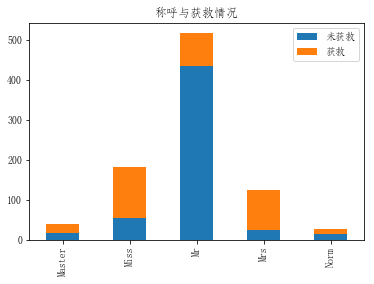

[ 32.36809045  21.7739726   35.89814815   4.57416667  42.38461538]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NameExtens,Name_num
5,6,0,3,"Moran, Mr. James",male,32.368090,0,0,8.4583,NaN,Q,Mr,0
17,18,1,2,"Williams, Mr. Charles Eugene",male,32.368090,0,0,13.0000,NaN,S,Mr,0
19,20,1,3,"Masselmani, Mrs. Fatima",female,35.898148,0,0,7.2250,NaN,C,Mrs,2
26,27,0,3,"Emir, Mr. Farred Chehab",male,32.368090,0,0,7.2250,NaN,C,Mr,0
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,21.773973,0,0,7.8792,NaN,Q,Miss,1
29,30,0,3,"Todoroff, Mr. Lalio",male,32.368090,0,0,7.8958,NaN,S,Mr,0
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,35.898148,1,0,146.5208,B78,C,Mrs,2
32,33,1,3,"Glynn, Miss. Mary Agatha",female,21.773973,0,0,7.7500,NaN,Q,Miss,1
36,37,1,3,"Mamee, Mr. Hanna",male,32.368090,0,0,7.2292,NaN,C,Mr,0
42,43,0,3,"Kraeff, Mr. Theodor",male,32.368090,0,0,7.8958,NaN,C,Mr,0


In [4]:
file_path='./dataset/train.csv'
data_train = pd.read_csv(file_path)
data_len=len(data_train)

data_pre = data_train.copy()
    # 预处理数据，离散的映射到类别空间，连续的映射到[0,1]
#     data_pre.drop(['Name', 'Ticket'], axis=1, inplace=True)
data_pre.drop(['Ticket'], axis=1, inplace=True)
#匹配Name并离散化为变量
data_pre['NameExtens'],data_pre['Name_num'] = setName(data_pre['Name'].copy())
showDataFig(data_pre[data_pre.Survived==1].NameExtens,data_pre[data_pre.Survived==0].NameExtens,'class','称呼与获救情况')

# 对缺失的Age，
has_Age=data_pre[pd.notnull(data_pre.Age)]
    #求称呼对应的年龄均值
Age_mean = [has_Age[has_Age.Name_num == 0]['Age'].mean(), has_Age[has_Age.Name_num == 1]['Age'].mean(),
                has_Age[has_Age.Name_num == 2]['Age'].mean(),has_Age[has_Age.Name_num == 3]['Age'].mean(),
                has_Age[has_Age.Name_num == 4]['Age'].mean()]
Age_mean = np.array(Age_mean)
print(Age_mean)
index=pd.isnull(data_pre.Age)
data_pre.loc[pd.isnull(data_pre.Age), 'Age'] = Age_mean[data_pre[pd.isnull(data_pre.Age)]['Name_num'].as_matrix()]
data_pre[index]


In [13]:
file_path='./dataset/test.csv'
data_test = pd.read_csv(file_path)
data_test[(data_train.Embarked.isnull())]

file_path='./dataset/train.csv'
data_train = pd.read_csv(file_path)
data_train[(data_train.Embarked.isnull())]
data_train



H:\Vision\Anconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
